<a href="https://colab.research.google.com/github/vikrantpotnis123/DS/blob/master/ssd_inference_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -qq Cython contextlib2 pillow lxml matplotlib pandas tf-slim

Selecting previously unselected package python-bs4.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow.compat.v1 as tf

In [ ]:
print(tf.__version__)

1.15.2


In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv
import re
import cv2 
import os
import glob
import xml.etree.ElementTree as ET

import io
import tensorflow.compat.v1 as tf

from PIL import Image
from collections import namedtuple, OrderedDict

import shutil
import urllib.request
import tarfile

from google.colab import files

In [ ]:
!nvidia-smi


Mon Jan 18 03:07:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
 
drive.mount('/gdrive')# the project's folder

Mounted at /gdrive


In [ ]:
%cd /gdrive/

/gdrive


In [ ]:
%ls

MyDrive/


In [ ]:
os.environ['PYTHONPATH'] += ':./:./slim/'

In [ ]:
!echo $PYTHONPATH

/tensorflow-1.15.2/python3.6:/env/python:./:./slim/


In [ ]:
%cd MyDrive/ssd_object_detection/models/research/

/gdrive/.shortcut-targets-by-id/1UzToM7fqvprtuC9Sm4zfmULBwjhthP-y/ssd_object_detection/models/research


In [ ]:
!python3 object_detection/builders/model_builder_tf1_test.py

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_model_from_config_wi

In [ ]:
tf.test.is_gpu_available()

True

In [ ]:
!pip install lvis

In [ ]:
%ls '/gdrive/MyDrive/ssd_object_detection/output_dir'

checkpoint                      model.ckpt.index  saved_model/
frozen_inference_graph.pb       model.ckpt.meta   tflite_graph.pb
model.ckpt.data-00000-of-00001  pipeline.config   tflite_graph.pbtxt


In [ ]:
# This is needed to display the images.
%matplotlib inline
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
MY_ROOT_DIR='/gdrive/MyDrive/ssd_object_detection'
PATH_TO_FROZEN_GRAPH = MY_ROOT_DIR + '/output_dir/frozen_inference_graph.pb'
PATH_TO_LABELS = MY_ROOT_DIR + '/vikrant_train/annotations/label_map.pbtxt'
NUM_CLASSES = 3
PATH_TO_TEST_IMAGES_DIR =   MY_ROOT_DIR+ '/vikrant_train/images/inference_test'

In [ ]:
# create empty graph and import graph definition by reading PATH_TO_FROZEN_GRAPH
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
print(category_index)

{1: {'id': 1, 'name': 'human leg'}, 2: {'id': 2, 'name': 'human head'}, 3: {'id': 3, 'name': 'human hand'}}


In [ ]:
def load_image_into_numpy_array(image):
  image.resize((300, 300))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# For the sake of simplicity we will use only 5 images:
# from image1.jpg
# to image5.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 7) ]


In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


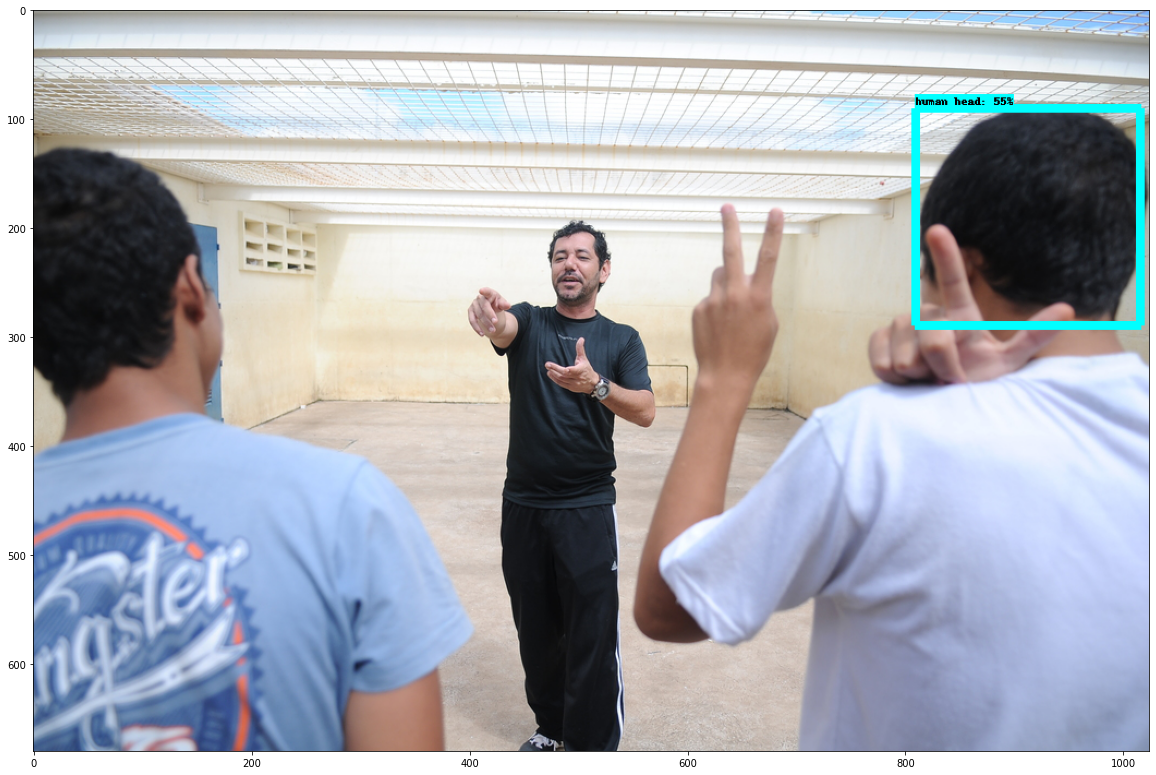

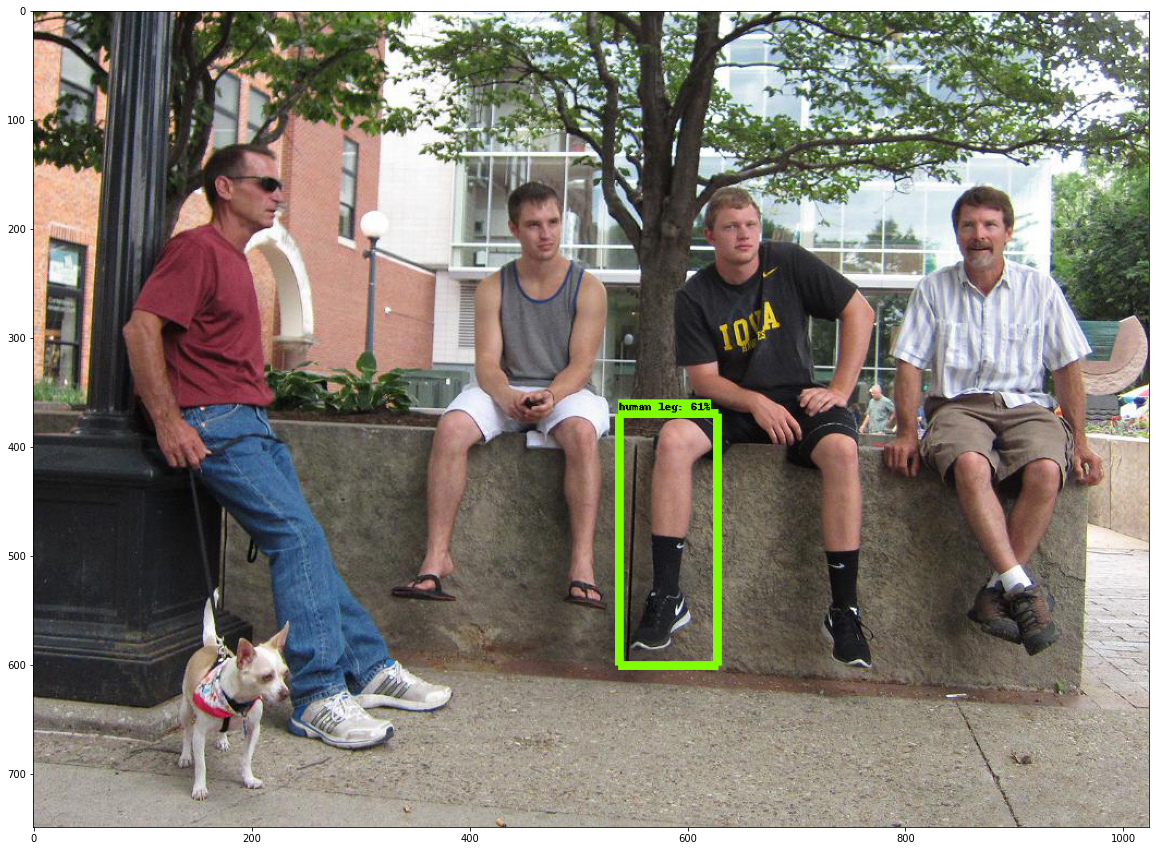

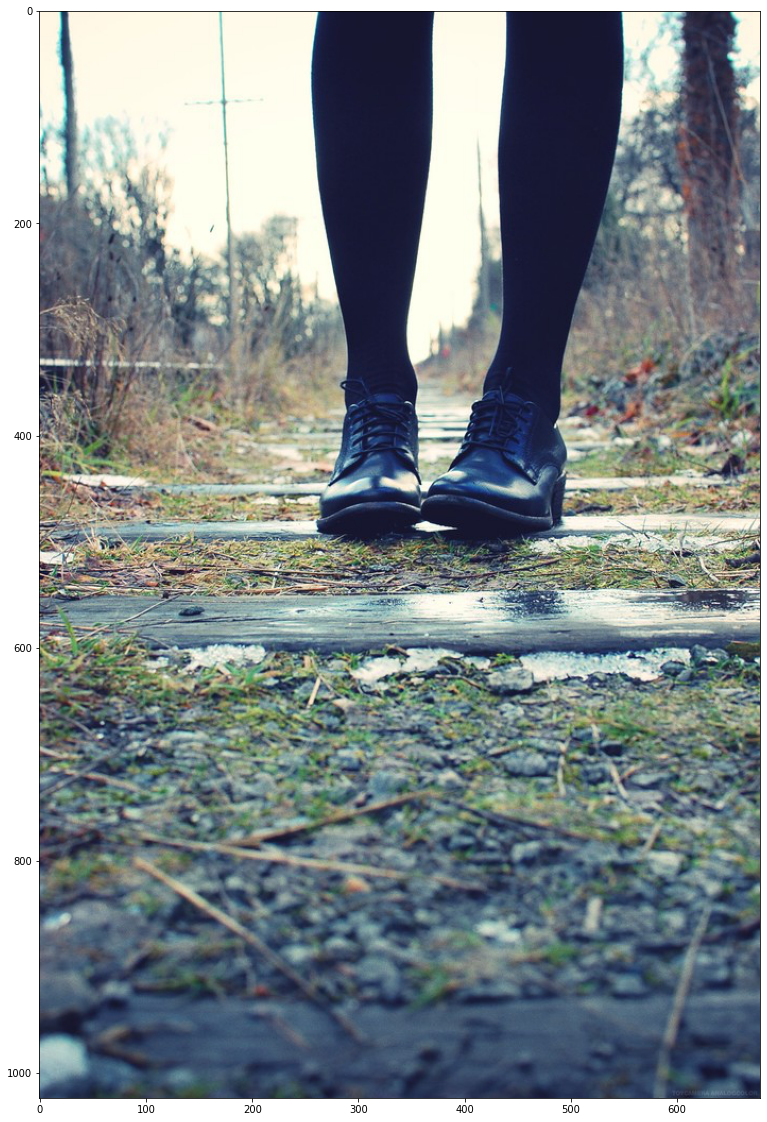

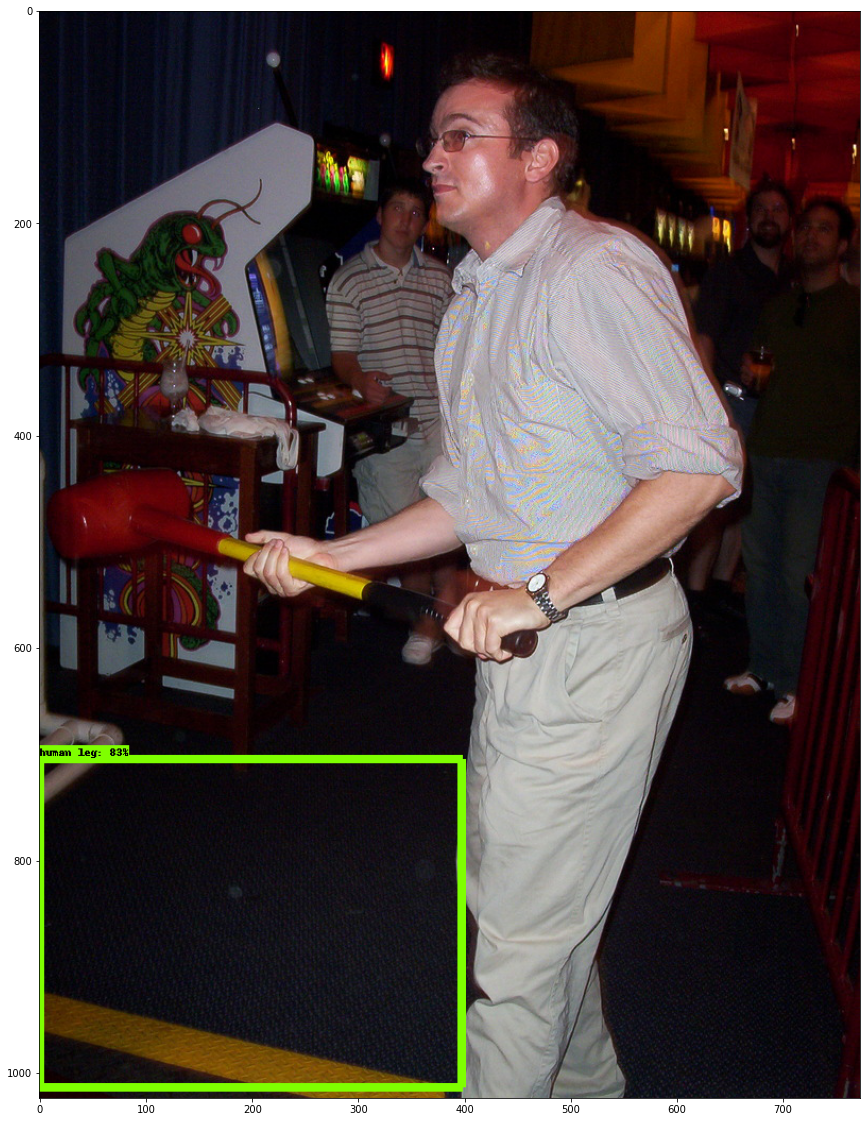

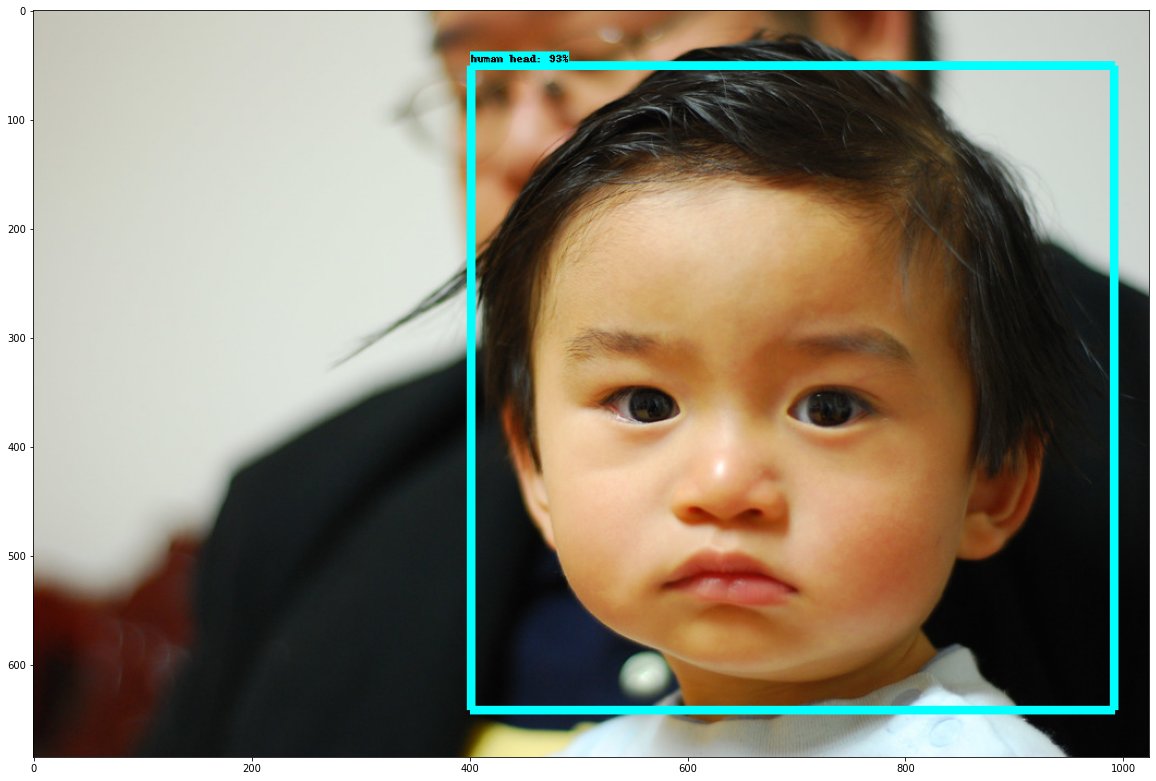

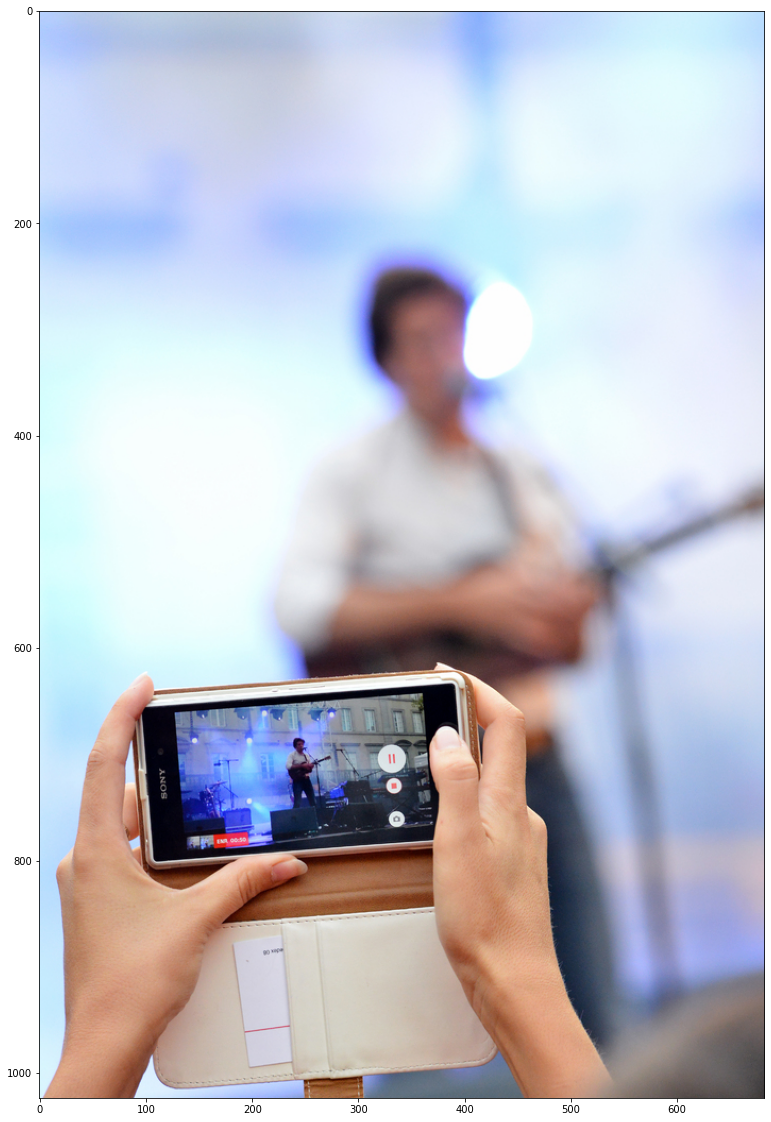

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=(20, 20))
  plt.imshow(image_np)